<a href="https://colab.research.google.com/github/EdwardMMiller/Data-Mining-Project---Fall-2022/blob/main/News_Classifier_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NEWS CLASSIFIER**

## DATA MINING - FALL 2022
## CUNY GRADUATE CENTER
## Edward Miller

## Overview

Over the past few decades, news sources have drastically shifted from print media to
online sites due to the widespread adoption of the internet by the general public. As a
consequence of this shift, it has become easier for news articles from untrustworthy
sources to pass themselves as real, and cause disinformation to spread rapidly. This
disinformation can cause widespread damage and is often used to push false narratives to
benefit a political party or a government. It has already caused harm to democratic
institutions by eroding trust in media sources, as well as motivating extreme actions based
on incorrect information, such as the Capitol Riots on January 6, 2021 . Therefore, it is now
more important than ever to develop sound methods for determining whether a news
story is real, or not. The intent of this project will be to use deep learning in order to train a
model that can correctly classify a list of news stories as real or not real.

## Goals
1. Train a deep learning model for binary classification to correctly classify whether a
news story is real
2. Test Trained Model on a dataset to determine how well it differentiates between the
two classes, and report findings.

## Dataset
The dataset, as well as the direct inspiration for this project, comes from the following kaggle
website, and the author of the code has some good insights that will be reused here as well.

https://www.kaggle.com/code/urkchar/determine-if-news-is-fake-or-real/notebook

Progress will be updated through Github here:

https://github.com/EdwardMMiller/Data-Mining-Project---Fall-2022/new/main

In [45]:
!pip install pandas
!pip install numpy
!pip install tensorflow==2.9.2'
!pip install keras
!pip3 install seaborn

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0


In [46]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import keras as K
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# libraries needed for 
# universal sentence encoder 

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

# function for later use of Universal Sentence Encoder 

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split
# importing sklearn packages

import re
# importing text library

import zipfile

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [47]:
URL_T = 'https://raw.githubusercontent.com/EdwardMMiller/Data-Mining-Project---Fall-2022/main/True.csv'
URL_F = "https://raw.githubusercontent.com/EdwardMMiller/Data-Mining-Project---Fall-2022/main/Fake.csv"
# getting data from Github

True_df = pd.read_csv(URL_T)
Fake_df = pd.read_csv(URL_F)
# getting the csv files into dataframe

print("Number of rows in True_df = ", True_df.shape[0])
print("Number of rows in Fake_df = ", Fake_df.shape[0])
print("Number of columns in True_df = ", True_df.shape[1])
print("Number of columns in Fake_df = ", Fake_df.shape[1])
# Checking number of rows and columns in each dataset

columns_list_T = True_df.columns.tolist()
columns_list_F = Fake_df.columns.tolist()
print("List of columns in True_df", columns_list_T)
print("List of columns in False_df", columns_list_T)
# checking to see if columns are the same
#%%
def data_file_explore(file, df):

  """
    This is a simple function designed to do surface level
    exploration of the data in a csv file. It will print the
    first five rows of a data file, number of rows and columns in the data file
    number of unique values in the data value, and the number of missing values
    in the data file. It also inputs the minimum, maximum, mean and median
    for the numeric columns, and then finds the mode for the column along with
    the number of times it appears in that column. Finally, it also gets the
    most frequent string found for the string columns along with the number of
    times that string is found in the column. It is assumed that the data
    that is being worked with is either numeric or a string.

  Args:
    file = string referencing the filename
    df = a data frame created from reading in the file
  Returns:
    none
  """
  
  print("*********************** FILE NAME: %s ***********************\n" %file)

  # This is just a file header

  print("First five rows in file: %s\n" %file)
  display(df.head())
  # looking at the first five rows of the data

  print("\nData types present in file: %s\n" %file)
  print(df.dtypes)
  # looking at data types found in the dataframe

  print("\nNumber of rows and columns in file: %s\n" %file)
  display(df.shape)
  # Getting the size of the dataset

  print("\nNumber of unique values for each column in file: %s\n" %file)
  display(df.nunique())
  # Looking at number of unique values

  print("\nCount of missing values in file: %s\n" %file)
  display(df.isnull().sum())
  print("")
  # Counting the missing values in the datasets

  for col in df.select_dtypes(include=np.number):
    # Looping through numeric columns in data frame a
      #print("Min for col %s = %s" %(col, df[col].min()))
      #print("Max for col %s = %s" %(col, df[col].max()))
    print("Numerical Stats for column - '%s' " % col)
    print("--------------------------------------------")
    (print("Min: %s Mean: %s"
           %(df[col].min(), df[col].mean() )))
    print("Max: %s Median: %s" %(df[col].max(), df[col].median()))
    # Printing the minimum, maximum, mean and median

    col_mode = df[col].value_counts().idxmax()
    # get the most frequent value in the column
    freq = df[col].value_counts()[col_mode]
    # get the count of the most frequent value in the column

    if freq > 1:
      print("Most frequent value: %s found in column %s times.\n" %(col_mode,freq))
    else:
      print("No value repetitions found in column\n")
      # Only returning the most frequent value if it appears more than once

  for col in df.select_dtypes(include=object):
      # Only looking at columns with strings now
    print("Frequency counts for string column - '%s' " % col)
    print("--------------------------------------------------")
    col_mode = df[col].value_counts().idxmax()
      # get the most frequent value in the column
    freq = df[col].value_counts()[col_mode]
      # get the count of the most frequent value in the column
    if freq > 1:
      (print("Most frequent string value: '%s' found in column %s times.\n"
               %(col_mode,freq)))
    else:
      print("No value repetitions found in column\n")
        # Only returning the most frequent value if it appears more than once

data_file_explore('True.csv', True_df)
data_file_explore('Fake.csv', Fake_df)


Number of rows in True_df =  21417
Number of rows in Fake_df =  23481
Number of columns in True_df =  4
Number of columns in Fake_df =  4
List of columns in True_df ['title', 'text', 'subject', 'date']
List of columns in False_df ['title', 'text', 'subject', 'date']
*********************** FILE NAME: True.csv ***********************

First five rows in file: True.csv



,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"



Data types present in file: True.csv

title      object
text       object
subject    object
date       object
dtype: object

Number of rows and columns in file: True.csv



(21417, 4)


Number of unique values for each column in file: True.csv



title      20826
text       21192
subject        2
date         716
dtype: int64


Count of missing values in file: True.csv



title      0
text       0
subject    0
date       0
dtype: int64


Frequency counts for string column - 'title' 
--------------------------------------------------
Most frequent string value: 'Factbox: Trump fills top jobs for his administration' found in column 14 times.

Frequency counts for string column - 'text' 
--------------------------------------------------
Most frequent string value: '(Reuters) - Highlights for U.S. President Donald Trump’s administration on Thursday: The United States drops a massive GBU-43 bomb, the largest non-nuclear bomb it has ever used in combat, in Afghanistan against a series of caves used by Islamic State militants, the Pentagon says. Trump says Pyongyang is a problem that “will be taken care of” amid speculation that North Korea is on the verge of a sixth nuclear test. Military force cannot resolve tension over North Korea, China warns, while an influential Chinese newspaper urges Pyongyang to halt its nuclear program in exchange for Beijing’s protection. The Trump administration is focusing its North Korea stra

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"



Data types present in file: Fake.csv

title      object
text       object
subject    object
date       object
dtype: object

Number of rows and columns in file: Fake.csv



(23481, 4)


Number of unique values for each column in file: Fake.csv



title      17903
text       17455
subject        6
date        1681
dtype: int64


Count of missing values in file: Fake.csv



title      0
text       0
subject    0
date       0
dtype: int64


Frequency counts for string column - 'title' 
--------------------------------------------------
Most frequent string value: 'MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead' found in column 6 times.

Frequency counts for string column - 'text' 
--------------------------------------------------
Most frequent string value: ' ' found in column 626 times.

Frequency counts for string column - 'subject' 
--------------------------------------------------
Most frequent string value: 'News' found in column 9050 times.

Frequency counts for string column - 'date' 
--------------------------------------------------
Most frequent string value: 'May 10, 2017' found in column 46 times.



## OVERVIEW OF DATA SETS

A cursory glance at the data shows that there are no missing values in either data set and that both column types
are the same along with matching data types. There are no numerical columns her, only text and dates. However, the author of the original project points out that the **True.csv** file  shows **WASHINGTON (Reuters) - ** or **SEATTLE/WASHINGTON (Reuters)** before the news articles. Also, there are **6** unique values for **'subject'** in the **Fake.csv** file and only **2** unique values for **'subject'** in the **True.csv**, which might cause the model while training the dataset to mainly look for these two things to determine whether the news article is fake. We will want to remove these things in order to ensure that it's not so obvious which one is which, and also ensure that the model will be able to work when classifying news stories that do not have this format, as one could then easily add the <Reuters> term to a fake news story, in order to trick the model into classifying it is as true.

In [48]:
cnt = 0
for row in True_df.index:
  if "(Reuters)" in True_df.loc[row]['text']:
     cnt = cnt + 1
print("Count of rows in True_df containing term (Reuters) = %s"% cnt )
print("Number of rows in True_df data frame = ", True_df.shape[0])
print("Percentage of rows in True_df containing (Reuters) = %s"% (cnt/True_df.shape[0]*100) )
print('')
# Counting the number of instances that contain the string "(Reuters)" in True_df

cnt = 0
for row in Fake_df.index:
  if "(Reuters)" in Fake_df.loc[row]['text']:
     cnt = cnt + 1
print("Count of rows in Fake_df containing term (Reuters) = %s"% cnt )
print("Number of rows in Fake_df data frame = ", Fake_df.shape[0])
print("Percentage of rows in Fake_df containing (Reuters) = %s"% (cnt/Fake_df.shape[0]*100) )
# Counting the number of instances that contain the string "(Reuters)" in Fake_df

Count of rows in True_df containing term (Reuters) = 21247
Number of rows in True_df data frame =  21417
Percentage of rows in True_df containing (Reuters) = 99.20623803520567

Count of rows in Fake_df containing term (Reuters) = 9
Number of rows in Fake_df data frame =  23481
Percentage of rows in Fake_df containing (Reuters) = 0.038328861632809505


As the original author also pointed out, this is something that needs to be addressed with the data before putting it into the model, as one can clearly see that over **99%** of the **True_df** rows contain the term **'(Reuters)'** and under **4%** of the rows in Fake_df contain this term. Let us also look at the 'subjects' column.

In [49]:
display(True_df['subject'].unique())
display(Fake_df['subject'].unique())
# looking at the unique values in the 'subjects' column

array(['politicsNews', 'worldnews'], dtype=object)

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

Using the **'subjects'** column in the model would be a dead give-away to the model as the unique values in the **Fake_df** and **True_df** are totally different and seeing one subject or the other would train the model to look for that subject when classifying the news article as real or fake.  Therefore, the text data needs to be pre-processed and the subject column needs to be removed as well. Also, in order to get a better look at just the text itself to see if a model can determine which class it belongs to, the date column will be removed as well.

In [50]:
def text_clean(string):
  """
  This function removes this pattern "^[A-Z/]+ \(Reuters\) - "
  from a text string
  :param string: A single string
  :return:  A single string with the pattern removed
  """
  reuters_pattern = "^[A-Z/]+ \(Reuters\) - "
  # String to remove at the start of True_df looks like
  # WASHINGTON (Reuters) - so saving this pattern
  return re.sub(reuters_pattern, "", string)
##########################################################################
test_string1 = True_df.loc[0]['text']
print("String before text_clean function applied\n")
print(test_string1)
print('')
# getting a test string to test function

print("String after text_clean function applied\n")
print(text_clean(test_string1))
print('')
# testing function to see if it removes string

def df_pre_processor(df_t, df_f, Shuffle = True):
  """ This is a basic pre-processing function that takes in
  the two dataframes True_df and Fake_df, adds correct labels
  to each, combines them, cleans the text column, removes unneeded
  columns and shuffles the dataframe

  :param df_t: a dataframe containing all true news articles
  :param df_f: a dataframe containing all fake news articles
  :param  Shuffle: bool = True
  :return: a pre-processed data frame combined from df_t & df_f
  """
  df_t['label'] = True
  df_f['label'] = False
  # adding correct labels to each

  df = pd.concat([df_t, df_f], axis=0)
  df['text'] = df['text'] .apply(text_clean)
  # combining both data frames and
  # applying text clean to the text column

  df = df.drop(["subject", 'date'],axis = 1)
  # removing two columns from df

  if Shuffle:
     df = shuffle(df).reset_index(drop=True)
  # shuffles the dataframe before returning it
  return df
##########################################################################
df_combined = df_pre_processor(True_df.copy(), Fake_df.copy())
# putting both dataframes in pre-processing function
display(df_combined.head())
# looking at new data frame
bool_test = True_df.shape[0] \
            + Fake_df.shape[0] \
            == df_combined.shape[0]
print("Will print %sTrue%s if total rows are equal - %s" % ("'","'",bool_test))
# checking to make sure new data frame has correct dimensions

String before text_clean function applied

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary

,title,text,label
0,FACEBOOK USER ARRESTED FOR “Offensive” Posts A...,"Only months ago, Obama s Attorney General, Lor...",False
1,Republicans may be on verge of losing U.S. Sen...,The Republican Party’s two-year run in the maj...,True
2,Turkey threatens sanctions over Kurdish indepe...,"HABUR BORDER CROSSING, Turkey (Reuters) - Turk...",True
3,EU embassies urge Romania to rethink judicial ...,Seven European Union states urged Romania s ru...,True
4,U.S. says strategy on North Korea centers on s...,U.S. President Donald Trump’s strategy on Nort...,True


Will print 'True' if total rows are equal - True


We now have a dataframe that can be used for the next steps. Our next step is to separate the data in train and test sections and the labels will need to be separated as well.  

In [62]:
columns_list = df_combined.columns[::].tolist()
columns_list.remove('label')
# saving columns list for features minus label
train_x, test_x, train_y, test_y = train_test_split(df_combined[columns_list],
                                                    df_combined['label'],
                                                    test_size=0.2,
                                                    random_state=5)
# Splitting data in train and test groups
display(train_x)
display(train_y)
display(test_x)
display(test_y)

,title,text
41124,WATCH: MEGYN KELLY HUMILIATES HERSELF (AGAIN)…...,One day after actress Debra Messing revealed...
22642,Student Haz A Sad After Everyone Mocks Him Fo...,"Now, typically no one should be mocking a teen..."
5161,Exclusive: U.S. group Sierra Club seeks probe ...,NEW YORK (Reuters) - U.S. environmental group ...
25434,The Internet Drags Trump’s Son For Saying ‘Th...,In the wake of Tom Koppel telling Sean Hannity...
2009,"South Africa's Dlamini-Zuma, ANC leadership co...",South African veteran politician and anti-apar...
...,...,...
5520,White House seen easing limits on drone strike...,The Trump administration is preparing to relax...
35814,Chelsea Manning says she was denied entry to C...,Chelsea Manning was turned back at the Canadia...
20463,"Trump aides, lawmakers hold talks to revive he...",Top White House officials met moderate and con...
18638,LADY IN RED: Watch President Trump and Our Stu...,A stunning Melania Trump accompanied President...


41124    False
22642    False
5161      True
25434    False
2009      True
         ...  
5520      True
35814     True
20463     True
18638    False
35683     True
Name: label, Length: 35918, dtype: bool

,title,text
10128,Trump says hopes for Cuban 'freedom' after Cas...,"WEST PALM BEACH, Fla. (Reuters) - U.S. Preside..."
43165,Trump taps net neutrality opponent Ajit Pai to...,President Donald Trump on Monday tapped Republ...
14627,Michigan state House approves carrying conceal...,(Reuters) - Legislation to allow Michigan gun ...
17654,CO GOP Swears Racist Anti-Obama Pic Was A Hac...,The Colorado GOP needs to get their stories st...
28412,(VIDEO) MINE OWNER HAMMERS EPA ON TOXIC SPILL ...,Gold King Mine Owner Todd Hennis says he warne...
...,...,...
16304,Divided Catalans prepare to vote in close-run ...,"VIC/CERDANYOLA DEL VALLES, Spain (Reuters) - C..."
24306,Senate kills rule meant to protect family plan...,"For the second time on Thursday, Vice Presiden..."
44244,CAR TORCHED AND SPRAYED WITH “F*CK TRUMP” Beca...,THE VICTIM SPEAKS OUT THIS IS SHAMEFUL! KPTV...
27014,U.S. lawmakers accuse Russia of seeking to inf...,The top Democrats on the U.S. Senate and House...


10128     True
43165     True
14627     True
17654    False
28412    False
         ...  
16304     True
24306     True
44244    False
27014     True
4424     False
Name: label, Length: 8980, dtype: bool

(35918, 2)

After separating the data into **80% train** and **20% test** sets, a **validation set** is still needed from the training set, so that the test set can be used only for scoring

In [76]:
train_row_cnt = train_x.shape[0]
# saving number of rows

val_row_cnt = train_x.shape[0]//5
# getting closest integer to 20% of the rows for validation set

val_x = train_x[0:val_row_cnt]
val_y = train_y[0:val_row_cnt]
# splitting validation set off from training set

train_xr = train_x[val_row_cnt:]
train_yr = train_y[val_row_cnt:]
# reduced training set

In [87]:
train_text = train_xr['text'].copy().to_numpy()
train_title = train_xr['title'].copy().to_numpy()
# both title and text into arrays for train set

val_text = val_x['text'].copy().to_numpy()
val_title = val_x['title'].copy().to_numpy()
# both title and text into arrays for val set

test_text = test_x['text'].copy().to_numpy()
test_title = test_x['title'].copy().to_numpy()
# both title and text into arrays for test set

train_label = train_yr.copy().astype(int)
val_label = val_y.copy().astype(int)
test_label = test_y.copy().astype(int)
# converting True or False to 1 and 0s

In [88]:
print(train_text.shape)
print(val_text.shape)

print(train_label.shape)
print(val_label.shape)
# checking the shapes of the reduced train and validation sets

(28735,)
(7183,)
(28735,)
(7183,)


Now, we will use the template from tensorflow's **Text Classification with Movie Reviews** from here, in order to build a neural network that can classify the text and also use a pre-trained data set

https://www.tensorflow.org/hub/tutorials/tf2_text_classification

The first pre-trained set is the **Universal Sentence Encoder**

In [99]:
model = "https://tfhub.dev/google/universal-sentence-encoder/4"
# Universal Sentence Encoder Model
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=False)
# Trainable set to false in order to leave these layers and use transfer learning

<tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.0517213 , -0.05552467, -0.02554719, ...,  0.06477965,
        -0.03829817,  0.03741699],
       [ 0.01887175,  0.0012712 , -0.03000113, ...,  0.02438172,
        -0.05895783,  0.03694998],
       [-0.00518859, -0.02642568, -0.05358518, ...,  0.05404968,
        -0.05267812,  0.03191903],
       ...,
       [ 0.03985505, -0.05399621, -0.02998513, ...,  0.05075805,
        -0.0346398 , -0.02686385],
       [-0.01549583, -0.05444679, -0.03725908, ...,  0.05627702,
        -0.04208824,  0.05308296],
       [ 0.00885177, -0.06402616, -0.05355963, ...,  0.06364772,
        -0.05794337,  0.05159787]], dtype=float32)>

In [100]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_16 (KerasLayer)  (None, 512)              256797824 
                                                                 
 dense_8 (Dense)             (None, 16)                8208      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 8,225
Non-trainable params: 256,797,824
_________________________________________________________________


In [101]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]
# if validation score doesn't improve with 10 eppchs, stop

In [102]:
history = model.fit(train_text,
                    train_label,
                    epochs=40,
                    batch_size=512,
                    validation_data=(val_text, val_label),
                    callbacks=callbacks, # early stopping line
                    verbose=1)
# This process takes a little over an hour

Epoch 1/40
57/57 [==============================] - 99s 2s/step - loss: 0.5727 - accuracy: 0.8095 - val_loss: 0.4446 - val_accuracy: 0.8799
Epoch 2/40
57/57 [==============================] - 93s 2s/step - loss: 0.3699 - accuracy: 0.8914 - val_loss: 0.3139 - val_accuracy: 0.9023
Epoch 3/40
57/57 [==============================] - 98s 2s/step - loss: 0.2786 - accuracy: 0.9094 - val_loss: 0.2546 - val_accuracy: 0.9135
Epoch 4/40
57/57 [==============================] - 97s 2s/step - loss: 0.2324 - accuracy: 0.9218 - val_loss: 0.2202 - val_accuracy: 0.9225
Epoch 5/40
57/57 [==============================] - 96s 2s/step - loss: 0.2044 - accuracy: 0.9298 - val_loss: 0.1981 - val_accuracy: 0.9300
Epoch 6/40
57/57 [==============================] - 96s 2s/step - loss: 0.1857 - accuracy: 0.9351 - val_loss: 0.1826 - val_accuracy: 0.9354
Epoch 7/40
57/57 [==============================] - 95s 2s/step - loss: 0.1724 - accuracy: 0.9404 - val_loss: 0.1715 - val_accuracy: 0.9396
Epoch 8/40
57/57 [==

In [103]:
results = model.evaluate(test_text, test_label)
print(results)

281/281 [==============================] - 14s 49ms/step - loss: 0.1244 - accuracy: 0.9494
[0.12443792074918747, 0.9494432210922241]


Here we have an accuracy of **94.94 %**, which is pretty high, especially since this is only using the text portion of the article for classification.

In [104]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

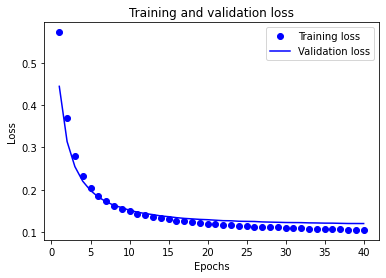

In [105]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

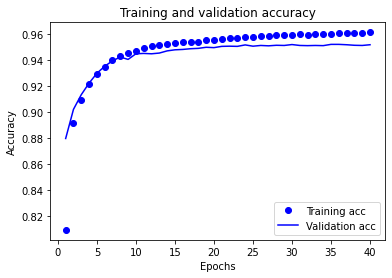

In [106]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# TEST WITH DIFFERENT PRE-PROCESSED TEXT CORPUS

#model = "https://tfhub.dev/google/nnlm-en-dim50/2"
#Token based text embedding trained on English Google News 7B corpus.



# New Section